# Biological interpretation

Moving from default params

In [2]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [45]:
import pandas as pd

import itertools

from tqdm import tqdm

import seaborn as sns

from math import floor


from matplotlib.colors import BoundaryNorm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable



from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    get_dose_colors
)


from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE,
)

from poly2.utils import (
    get_dispersal_kernel, trait_vec, beta_dist, gamma_dist,
    get_dist_var, get_dist_mean, edge_values, 
    get_best_dose_for_cb
)

from poly2.run import get_data_from_pars
from poly2.config import Config
from poly2.simulator import SimulatorOneTrait
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

# Fig 7

In [4]:
HEIGHT = 4
WIDTH = 8

MAX_DISPLAY = 8

In [5]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

459, 1626, 3961, 6856, 9382

## Run these

In [7]:
cfd = Config(verbose=False)

In [106]:
pars1 = dict(
    mu=12,
    b=cfd.k_b,
    asymp=1,
    dec_rate=0.35,
    m_prop=1,
    m_scale=1,
)

pars2 = dict(
    mu=1,
    b=cfd.k_b,
    asymp=0.5,
    dec_rate=2,
    m_prop=1,
    m_scale=1,
)


pars3 = dict(
    mu=cfd.k_mu,
    b=cfd.k_b,
    asymp=1,
    dec_rate=1,
    m_prop=0.5,
    m_scale=7.5,
)


pars4 = dict(
    mu=cfd.k_mu,
    b=cfd.k_b,
    asymp=1,
    dec_rate=1,
    m_prop=7.5,
    m_scale=0.5,
)

# Test

In [39]:
def get_data_test(pars, nd=10):

    n_years = 35

    cf = Config(
        n_years=n_years,
        n_k=300,
        verbose=False
    )

    cf.k_mu = pars['mu']
    cf.k_b = pars['b']
    cf.asymptote = pars['asymp']
    cf.decay_rate = FUNG_DECAY_RATE * pars['dec_rate']
    cf.mutation_proportion = MUTATION_PROP * pars['m_prop']
    cf.mutation_scale_fung = MUTATION_SCALE * pars['m_scale']
    
    out = []

    for dose in tqdm(np.linspace(0.1, 1, nd)):

        cf.doses = dose*np.ones(cf.n_years)

        sim = SimulatorOneTrait(cf)

        data = sim.run_model()
        
        out.append(data)
        
    return out

In [111]:
line_df1 = get_data_from_pars(pars1, n_d=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.34s/it]


In [46]:
out = line_df1

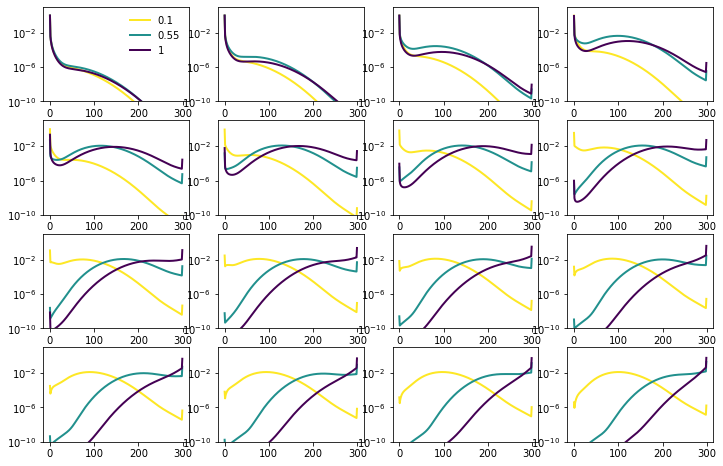

In [102]:
f, ax = plt.subplots(4,4, figsize=(12,8))

yy=0
cols = get_dose_colors(3)
for ind, yy in enumerate(np.arange(1, 17, 1)):
    
    # ind = 2
    # cc = cols[ind]
    
    col = ind%4
    rr = floor(ind/4)
    
    # cc = cols[2]
    
    ax[rr][col].plot(out[0]['fung_dists'][:, yy], c=cols[0], label='0.1', lw=2) #label=f'{yy=}', 
    ax[rr][col].plot(out[1]['fung_dists'][:, yy], c=cols[1], label='0.55', lw=2)
    ax[rr][col].plot(out[2]['fung_dists'][:, yy], c=cols[2], label='1', lw=2)

    ax[rr][col].set_yscale('log')

    ax[rr][col].set_ylim([1e-10, 10])

ax[0][0].legend(frameon=False)

In [117]:
line_df1

,dose,yld,fung_mean,year
0,0.1,NaN,0.001850,0
1,0.1,10.271961,0.002018,1
2,0.1,10.269566,0.002395,2
3,0.1,10.264926,0.003318,3
4,0.1,10.255350,0.005746,4
...,...,...,...,...
31,1.0,8.830647,0.996039,31
32,1.0,8.829777,0.996204,32
33,1.0,8.829000,0.996351,33
34,1.0,8.828302,0.996483,34


In [118]:
bd_use1 = get_best_dose_for_cb(line_df1, 10.7)

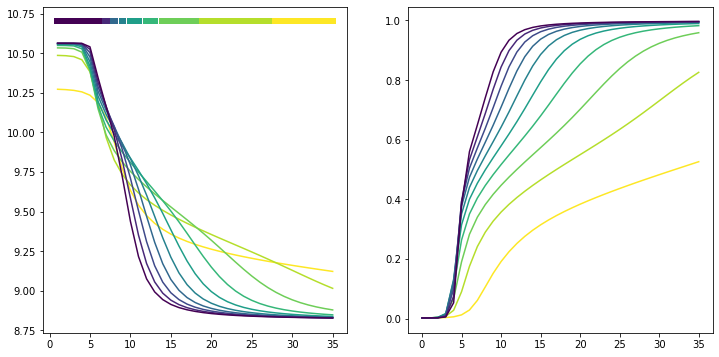

In [120]:
f, ax = plt.subplots(1, 2, figsize=(12,6))

doses = line_df1.dose.unique()

COLZ = get_dose_colors(10)

# A
for ind, dose in enumerate(doses):
    
    n_d = len(doses)
    
    colr = COLZ[ind]
    
    ax[0].plot(
        line_df1.loc[lambda x: x.dose==dose].year,
        line_df1.loc[lambda x: x.dose==dose].yld,
        c=colr
    )
    
    ax[1].plot(
        line_df1.loc[lambda x: x.dose==dose].year,
        line_df1.loc[lambda x: x.dose==dose].fung_mean,
        c=colr
    )
    
    ax[0].plot(
        bd_use1.loc[lambda x: x.dose==dose].year,
        bd_use1.loc[lambda x: x.dose==dose].yy,
        c=colr,
        lw=6
    )


# Continue

In [121]:
%%time

line_df1 = get_data_from_pars(pars1)
line_df2 = get_data_from_pars(pars2)
line_df3 = get_data_from_pars(pars3)
line_df4 = get_data_from_pars(pars4)

line_df1.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.26s/it]

Wall time: 14min 22s


,dose,yld,fung_mean,year
0,0.1,NaN,0.001850,0
1,0.1,10.271961,0.002018,1
2,0.1,10.269566,0.002395,2
3,0.1,10.264926,0.003318,3
4,0.1,10.255350,0.005746,4


In [122]:
bd_use1 = get_best_dose_for_cb(line_df1, 10.7)
bd_use2 = get_best_dose_for_cb(line_df2, 9.15)
bd_use3 = get_best_dose_for_cb(line_df3, 10.65)
bd_use4 = get_best_dose_for_cb(line_df4, 10.65)

## Fig

Wall time: 7.02 s


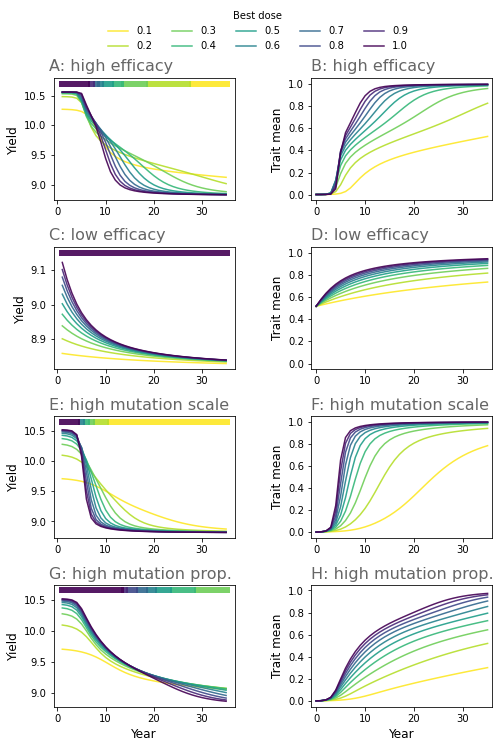

In [123]:
%%time

plt.close('all')

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title


f, ax = plt.subplots(4, 2, figsize=(8, 10))

alpha = 0.9

COLZ = get_dose_colors()

# DATA

doses = line_df1.dose.unique()

# A
for ind, dose in enumerate(doses):
    
    # if np.isnan(dose):
    #     continue

    n_d = len(doses)
    
    colr = COLZ[ind]
    
    # A
    ax[0][0].plot(line_df1.loc[lambda x: x.dose==dose].year,
            line_df1.loc[lambda x: x.dose==dose].yld,
            label=f'{dose:.1f}',
            alpha=alpha,
            c=colr)
    
    ax[0][0].plot(bd_use1.loc[lambda x: x.dose==dose].year,
            bd_use1.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)
    
    # C
    ax[1][0].plot(line_df2.loc[lambda x: x.dose==dose].year,
            line_df2.loc[lambda x: x.dose==dose].yld,
            alpha=alpha,
            c=colr)
    
    ax[1][0].plot(bd_use2.loc[lambda x: x.dose==dose].year,
            bd_use2.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)
    
        
    # E
    ax[2][0].plot(line_df3.loc[lambda x: x.dose==dose].year,
            line_df3.loc[lambda x: x.dose==dose].yld,
            alpha=alpha,
            c=colr)
    
    ax[2][0].plot(bd_use3.loc[lambda x: x.dose==dose].year,
            bd_use3.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)

    # G
    ax[3][0].plot(line_df4.loc[lambda x: x.dose==dose].year,
            line_df4.loc[lambda x: x.dose==dose].yld,
            alpha=alpha,
            c=colr)
    
    ax[3][0].plot(bd_use4.loc[lambda x: x.dose==dose].year,
            bd_use4.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)
    
    # B
    ax[0][1].plot(line_df1.loc[lambda x: x.dose==dose].year,
            line_df1.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    # D
    ax[1][1].plot(line_df2.loc[lambda x: x.dose==dose].year,
            line_df2.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    
    # F
    ax[2][1].plot(line_df3.loc[lambda x: x.dose==dose].year,
            line_df3.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    
    # H
    ax[3][1].plot(line_df4.loc[lambda x: x.dose==dose].year,
            line_df4.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    

    
# LAYOUT

# A

# B

# C

# D

# E

# F

# G

# H


for ii, jj in itertools.product(np.arange(4), np.arange(2)):
    # ax[ii][jj].spines['top'].set_visible(True)
    # ax[ii][jj].spines['right'].set_visible(True)

    # ax[ii][jj].set_ylim([ymin, ymax])
    
    # ax[ii][jj].set_xticks([1,10,20,30])
    ax[ii][jj].set_xticks([0,10,20,30])
    ax[ii][jj].set_xticklabels([0,10,20,30], rotation=0)
    
    if jj==0:
        ax[ii][jj].set_ylabel('Yield')
    else:
        ax[ii][jj].set_ylabel('Trait mean')
        ax[ii][jj].set_xlim([-1, 36])
        ax[ii][jj].set_ylim([-0.05, 1.05])
        # ax[ii][jj].set_yticks([0,0.5,1])
        
    if ii==3:
        ax[ii][jj].set_xlabel('Year')
    else:
        ax[ii][jj].set_xlabel('')

f.patch.set_facecolor('white')

plt.tight_layout(rect=[0, 0, 0.88, 0.95], h_pad=3, w_pad=3)

labels = 'ABCDEFGHIJKLMNOP'
labels = [
    'A: high efficacy',
    'B: high efficacy',
    'C: low efficacy',
    'D: low efficacy',
    'E: high mutation scale',
    'F: high mutation scale',
    'G: high mutation prop.',
    'H: high mutation prop.',
]

get_corner_annotations_custom_labels(2, 4, 0.085, 0.94, 0.455, 0.235, plt, labels)

ax[0][0].legend(
    bbox_to_anchor=(0.25, 1.15),
    loc='lower left',
    framealpha=0,
    ncol=5,
    title='Best dose',
)

# f

In [124]:
f.savefig('../figures/paper/fig7.jpg', dpi=1200, bbox_inches="tight")